In [3]:
from keras.applications import inception_v3
from keras import backend as K
import numpy as np
import scipy
import matplotlib.pyplot as plt
from keras.preprocessing import image
from utils import *
% matplotlib inline

In [7]:
K.set_learning_phase(0) # disable all training of the model weights
model = inception_v3.InceptionV3(weights='imagenet', include_top=False)

In [3]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, None, 3 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, None, None, 3 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

# Exercices

<span style=color:blue>Pictures of homogenous view (sky, grass land, desert) are actually easier for the neural network to modify, has there is not much petterns already in place<span>

## Playground exercice one:
The layers of the neural network contain filters that are the patterns that will appear on your picture.

Early layers contain basic patterns, like horizontal lines, simple textures... 
Later layers contain more elaborate patterns, like house shape, eyes, ears...

<b>Modify the layers used in</b> `layer_contibutions` <b>for computing the loss, and observe the impact it has on your generated picture.</b>

The modification can happen in three ways:

1. Modify the number of layers.
2. Modify the weight of the layers
3. Change which layers are used.

Hint: 
- Look at the `model.summary()` to know the name of the layers.
- The layers named `mixed` and `conV2D` are the most significant to use.

<span style=color:red>After modifying `layer_contribution` you need to run the other cells to update the computational graph<span>


In [7]:
layer_contributions = {
    'conv2d_52': 10.,
    'mixed5': 5.,
    'mixed6': 2.,
    }

In [8]:
##########################################
# RUN THIS CELL TO UPDATE THE GRAPH
# NO NEED TO CHANGE THIS CODE


layer_dict = dict([(layer.name, layer) for layer in model.layers]) # map layer_name -> instance

loss = K.variable(0.) # initialize loss to 0
for layer_name in layer_contributions:
    coeff = layer_contributions[layer_name]
    activation = layer_dict[layer_name].output
    scaling = K.prod(K.cast(K.shape(activation), 'float32')) # number of activation in a layer
    # avoid border effect by selecting 2:-2 
    loss += coeff * K.sum(K.square(activation[:,2:-2, 2:-2, :])) / scaling
    # Gradient ascent
    
dream = model.input
grads = K.gradients(loss, dream)[0]  # gradient of the input with regard to the loss.
grads /= K.maximum(K.mean(K.abs(grads)), 1e-7) # normalize gradient (like clipping)

outputs = [loss, grads]
fetch_loss_and_grads = K.function([dream], outputs)

def eval_loss_and_grads(x):
    outs = fetch_loss_and_grads([x])
    loss_value = outs[0]
    grad_values = outs[1]
    return loss_value, grad_values
   
def gradient_ascent(picture, iterations, learning_rate, max_loss=None):
    for i in range(iterations):
        loss_value, gradient_values = eval_loss_and_grads(picture)
        if (max_loss!=None) and (loss_value>max_loss):
            # Stop the algorithm after a Maximum loss threshold 
            break
        print('...Loss value at', i, ':', loss_value)
        picture = picture + learning_rate*gradient_values
    return picture

In [9]:
# running gradient ascent of different sceles of image
def main(base_image_path):
    learning_rate = 0.01
    num_octave = 3
    octave_scale = 1.4
    iterations = 20
    max_loss = 10 

    img = preprocess_image(base_image_path)
    original_shape = img.shape[1:3]
    successive_shapes = [original_shape]
    for i in range(1, num_octave):
        shape = tuple([int(dim / (octave_scale ** i)) for dim in original_shape])
        successive_shapes.append(shape)
    successive_shapes = successive_shapes[::-1]
    original_img = np.copy(img)
    shrunk_original_img = resize_img(img, successive_shapes[0]) # srunk to first scale

    for shape in successive_shapes:
        print('Processing image shape', shape)
        img = resize_img(img, shape)
        img = gradient_ascent(img,
                              iterations=iterations,
                              learning_rate=learning_rate,
                              max_loss=max_loss)
        upscaled_shrunk_original_img = resize_img(shrunk_original_img, shape)
        same_size_original = resize_img(original_img, shape)
        lost_detail = same_size_original - upscaled_shrunk_original_img
        img += lost_detail
        shrunk_original_img = resize_img(original_img, shape)
        save_img(img, fname='output/dream_at_scale_' + str(shape) + '.png')
    save_img(img, fname='output/final_dream.png')

In [10]:
# Run the generative model
main('./dream/sky.JPG')

Processing image shape (366, 653)
...Loss value at 0 : 2.448592
...Loss value at 1 : 3.6646802
...Loss value at 2 : 5.17015
...Loss value at 3 : 6.728642
...Loss value at 4 : 8.385723
...Loss value at 5 : 9.875048
Processing image shape (512, 914)
...Loss value at 0 : 4.475424
...Loss value at 1 : 7.306331
...Loss value at 2 : 8.684753
Processing image shape (718, 1280)
...Loss value at 0 : 4.304409
...Loss value at 1 : 6.9515243
...Loss value at 2 : 8.382611


## Playground exercice two:
The learning rate define the speed at which the NN will reach a local optimum.

The max_loss cap the algorithm to not exceed a certain loss.

<b>Modify the max_loss to see a more dramatic change in the image.</b>

<b>Modify the learning rate to observe a speed-up in the loss increase.</b>


Hint: 
- This will happens in the `main()` function.
- A modification or `learning_rate` by a factor 10 is already a big change.

<span style=color:red>If you only modify the `main()` function you won't need to update the computational graph<span>

In [15]:
##############################
# Edit the contibuting layers

layer_contributions = {
    'conv2d_52': 25.,
    }

In [16]:
####################################
# RUN THIS CELL TO UPDATE THE GRAPH
# NO NEED TO CHANGE THIS CODE


layer_dict = dict([(layer.name, layer) for layer in model.layers]) # map layer_name -> instance

loss = K.variable(0.) # initialize loss to 0
for layer_name in layer_contributions:
    coeff = layer_contributions[layer_name]
    activation = layer_dict[layer_name].output
    scaling = K.prod(K.cast(K.shape(activation), 'float32')) # number of activation in a layer
    # avoid border effect by selecting 2:-2 
    loss += coeff * K.sum(K.square(activation[:,2:-2, 2:-2, :])) / scaling
    # Gradient ascent
    
dream = model.input
grads = K.gradients(loss, dream)[0]  # gradient of the input with regard to the loss.
grads /= K.maximum(K.mean(K.abs(grads)), 1e-7) # normalize gradient (like clipping)

outputs = [loss, grads]
fetch_loss_and_grads = K.function([dream], outputs)

def eval_loss_and_grads(x):
    outs = fetch_loss_and_grads([x])
    loss_value = outs[0]
    grad_values = outs[1]
    return loss_value, grad_values
   
def gradient_ascent(picture, iterations, learning_rate, max_loss=None):
    for i in range(iterations):
        loss_value, gradient_values = eval_loss_and_grads(picture)
        if (max_loss!=None) and (loss_value>max_loss):
            # Stop the algorithm after a Maximum loss threshold 
            break
        print('...Loss value at', i, ':', loss_value)
        picture = picture + learning_rate*gradient_values
    return picture

In [17]:
############################################################
# Edit the learning rate to speed up the modification
# Edit the max_loss to increase the modification of the image


def main(base_image_path):
    learning_rate = 0.01
    num_octave = 3
    octave_scale = 1.4
    iterations = 20
    max_loss = 100

    img = preprocess_image(base_image_path)
    original_shape = img.shape[1:3]
    successive_shapes = [original_shape]
    for i in range(1, num_octave):
        shape = tuple([int(dim / (octave_scale ** i)) for dim in original_shape])
        successive_shapes.append(shape)
    successive_shapes = successive_shapes[::-1]
    original_img = np.copy(img)
    shrunk_original_img = resize_img(img, successive_shapes[0]) # srunk to first scale

    for shape in successive_shapes:
        print('Processing image shape', shape)
        img = resize_img(img, shape)
        img = gradient_ascent(img,
                              iterations=iterations,
                              learning_rate=learning_rate,
                              max_loss=max_loss)
        upscaled_shrunk_original_img = resize_img(shrunk_original_img, shape)
        same_size_original = resize_img(original_img, shape)
        lost_detail = same_size_original - upscaled_shrunk_original_img
        img += lost_detail
        shrunk_original_img = resize_img(original_img, shape)
        save_img(img, fname='output/dream_at_scale_' + str(shape) + '.png')
    save_img(img, fname='output/final_dream.png')

In [20]:
main('./dream/sky.JPG')

Processing image shape (366, 653)
...Loss value at 0 : 4.4474545
...Loss value at 1 : 6.882981
...Loss value at 2 : 9.74409
...Loss value at 3 : 12.532616
...Loss value at 4 : 15.60267
...Loss value at 5 : 18.938816
...Loss value at 6 : 21.85651
...Loss value at 7 : 24.83817
...Loss value at 8 : 28.14423
...Loss value at 9 : 32.22948
...Loss value at 10 : 34.971424
...Loss value at 11 : 37.868378
...Loss value at 12 : 41.166203
...Loss value at 13 : 44.495213
...Loss value at 14 : 48.371857
...Loss value at 15 : 51.09748
...Loss value at 16 : 54.586388
...Loss value at 17 : 56.792393
...Loss value at 18 : 61.2232
...Loss value at 19 : 63.400944
Processing image shape (512, 914)
...Loss value at 0 : 11.042963
...Loss value at 1 : 20.593567
...Loss value at 2 : 25.513317
...Loss value at 3 : 30.28683
...Loss value at 4 : 33.489307
...Loss value at 5 : 38.288555
...Loss value at 6 : 41.162975
...Loss value at 7 : 45.552723
...Loss value at 8 : 49.066944
...Loss value at 9 : 52.121178
...L

## Advance exercice
Observe a filter pattern
Create a noise input picture.
Select only one filter

In [16]:
for l in model.layers:
    if l.name=='mixed2':
        layer = l
activation = l.output
print(activation.shape)

TensorShape([Dimension(None), Dimension(None), Dimension(None), Dimension(2048)])

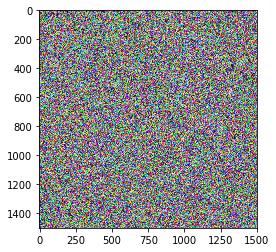

In [24]:
noise_input = np.random.random((1500, 1500, 3)) * 20 + 128
plt.imshow(noise_input)

In [16]:
layer_contributions = {
    'mixed5': 20.,
    }

In [17]:
# LOSS
layer_dict = dict([(layer.name, layer) for layer in model.layers]) # map layer_name -> instance

loss = K.variable(0.) # initialize loss to 0
for layer_name in layer_contributions:
    coeff = layer_contributions[layer_name]
    activation = layer_dict[layer_name].output[:,:,:,10]
    scaling = K.prod(K.cast(K.shape(activation), 'float32')) # number of activation in a layer
    # avoid border effect by selecting 2:-2 
    loss += coeff * K.sum(K.square(activation[:,2:-2, 2:-2])) / scaling

In [18]:
# Gradient ascent
dream = model.input
grads = K.gradients(loss, dream)[0]  # gradient of the input with regard to the loss.
grads /= K.maximum(K.mean(K.abs(grads)), 1e-7) # normalize gradient (like clipping)

outputs = [loss, grads]
fetch_loss_and_grads = K.function([dream], outputs)

def eval_loss_and_grads(x):
    outs = fetch_loss_and_grads([x])
    loss_value = outs[0]
    grad_values = outs[1]
    return loss_value, grad_values
   
def gradient_ascent(x, iterations, step, max_loss=None):
    for i in range(iterations):
        loss_value, grad_values = eval_loss_and_grads(x)
        if max_loss!=None and loss_value>max_loss:
            break
        print('...Loss value at', i, ':', loss_value)
        x += step*grad_values
    return x

In [23]:
# running gradient ascent of different sceles of image
step = 0.01
num_octave = 3
octave_scale = 1.4
iterations = 50
max_loss = 10000
base_image_path = './dream/rome.jpg'

#img = preprocess_image(base_image_path)
img = np.expand_dims(noise_input, axis=0)
img = inception_v3.preprocess_input(img)
original_shape = img.shape[1:3]
successive_shapes = [original_shape]
for i in range(1, num_octave):
    shape = tuple([int(dim / (octave_scale ** i)) for dim in original_shape])
    successive_shapes.append(shape)
successive_shapes = successive_shapes[::-1]
original_img = np.copy(img)
shrunk_original_img = resize_img(img, successive_shapes[0]) # srunk to first scale


for shape in successive_shapes:
    print('Processing image shape', shape)
    img = resize_img(img, shape)
    img = gradient_ascent(img,
                          iterations=iterations,
                          step=step,
                          max_loss=max_loss)
    break
#     upscaled_shrunk_original_img = resize_img(shrunk_original_img, shape)
#     same_size_original = resize_img(original_img, shape)
#     lost_detail = same_size_original - upscaled_shrunk_original_img
#     img += lost_detail
#     shrunk_original_img = resize_img(original_img, shape)
#    save_img(img, fname='dream_at_scale_' + str(shape) + '.png')
    
save_img(img, fname='final_dream.png')

Processing image shape (765, 765)
...Loss value at 0 : 0.568134
...Loss value at 1 : 2.009834
...Loss value at 2 : 3.2584395
...Loss value at 3 : 14.96304
...Loss value at 4 : 40.607468
...Loss value at 5 : 93.864174
...Loss value at 6 : 162.03555
...Loss value at 7 : 238.43994
...Loss value at 8 : 321.88388
...Loss value at 9 : 411.09735
...Loss value at 10 : 505.15384
...Loss value at 11 : 602.56726
...Loss value at 12 : 698.01013
...Loss value at 13 : 793.46985
...Loss value at 14 : 889.5563
...Loss value at 15 : 985.66113
...Loss value at 16 : 1080.3029
...Loss value at 17 : 1172.4465
...Loss value at 18 : 1266.7482
...Loss value at 19 : 1367.0638
...Loss value at 20 : 1462.2235
...Loss value at 21 : 1554.958
...Loss value at 22 : 1639.8036
...Loss value at 23 : 1735.7267
...Loss value at 24 : 1818.7911
...Loss value at 25 : 1906.7181
...Loss value at 26 : 1983.4601
...Loss value at 27 : 2071.0115
...Loss value at 28 : 2153.4734
...Loss value at 29 : 2228.3684
...Loss value at 30 :

In [38]:
layer_contributions = {
    'conv2d_61': 25.,
    }

In [39]:
# LOSS
layer_dict = dict([(layer.name, layer) for layer in model.layers]) # map layer_name -> instance

loss = K.variable(0.) # initialize loss to 0
for layer_name in layer_contributions:
    coeff = layer_contributions[layer_name]
    activation = layer_dict[layer_name].output[:,:,:,81]
    scaling = K.prod(K.cast(K.shape(activation), 'float32')) # number of activation in a layer
    # avoid border effect by selecting 2:-2 
    loss += coeff * K.sum(K.square(activation[:,2:-2, 2:-2])) / scaling

In [40]:
# Gradient ascent
dream = model.input
grads = K.gradients(loss, dream)[0]  # gradient of the input with regard to the loss.
grads /= K.maximum(K.mean(K.abs(grads)), 1e-7) # normalize gradient (like clipping)

outputs = [loss, grads]
fetch_loss_and_grads = K.function([dream], outputs)

def eval_loss_and_grads(x):
    outs = fetch_loss_and_grads([x])
    loss_value = outs[0]
    grad_values = outs[1]
    return loss_value, grad_values
   
def gradient_ascent(x, iterations, step, max_loss=None):
    for i in range(iterations):
        loss_value, grad_values = eval_loss_and_grads(x)
        if max_loss!=None and loss_value>max_loss:
            break
        print('...Loss value at', i, ':', loss_value)
        x += step*grad_values
    return x

In [41]:
# running gradient ascent of different sceles of image
step = 0.05
num_octave = 3
octave_scale = 1.4
iterations = 40
max_loss = 10000
base_image_path = './dream/rome.jpg'

#img = preprocess_image(base_image_path)
img = np.expand_dims(noise_input, axis=0)
img = inception_v3.preprocess_input(img)
original_shape = img.shape[1:3]
successive_shapes = [original_shape]
for i in range(1, num_octave):
    shape = tuple([int(dim / (octave_scale ** i)) for dim in original_shape])
    successive_shapes.append(shape)
successive_shapes = successive_shapes[::-1]
original_img = np.copy(img)
shrunk_original_img = resize_img(img, successive_shapes[0]) # srunk to first scale


for shape in successive_shapes:
    print('Processing image shape', shape)
    img = resize_img(img, shape)
    img = gradient_ascent(img,
                          iterations=iterations,
                          step=step,
                          max_loss=max_loss)
    break
#     upscaled_shrunk_original_img = resize_img(shrunk_original_img, shape)
#     same_size_original = resize_img(original_img, shape)
#     lost_detail = same_size_original - upscaled_shrunk_original_img
#     img += lost_detail
#     shrunk_original_img = resize_img(original_img, shape)
#    save_img(img, fname='dream_at_scale_' + str(shape) + '.png')
    
save_img(img, fname='final_dream.png')

Processing image shape (765, 765)
...Loss value at 0 : 9.783728
...Loss value at 1 : 3.2645414
...Loss value at 2 : 8.892921
...Loss value at 3 : 21.222885
...Loss value at 4 : 38.454514
...Loss value at 5 : 63.747246
...Loss value at 6 : 93.898994
...Loss value at 7 : 131.44702
...Loss value at 8 : 165.36833
...Loss value at 9 : 201.92851
...Loss value at 10 : 239.32668
...Loss value at 11 : 284.1565
...Loss value at 12 : 334.02698
...Loss value at 13 : 382.8259
...Loss value at 14 : 442.81235
...Loss value at 15 : 494.04532
...Loss value at 16 : 552.29895
...Loss value at 17 : 615.8795
...Loss value at 18 : 680.2987
...Loss value at 19 : 731.36456
...Loss value at 20 : 792.249
...Loss value at 21 : 872.48474
...Loss value at 22 : 936.86334
...Loss value at 23 : 998.806
...Loss value at 24 : 1071.7021
...Loss value at 25 : 1144.8406
...Loss value at 26 : 1224.3263
...Loss value at 27 : 1301.5828
...Loss value at 28 : 1370.557
...Loss value at 29 : 1456.6022
...Loss value at 30 : 1527.